**Capone Aldo**

**Matricola 0001034517**

**Step B** *- Multiple Instance Detection*:

Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}

Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In addition to what achieved at step A, the system should now be able to detect multiple instance of the
same product. Purposely, students may deploy local invariant feature together with the GHT (Generalized
Hough Transform). More precisely, rather than relying on the usual R-Table, the object model acquired at
training time should now consist in vectors joining all the features extracted in the model image to their
barycenter; then, at run time all the image features matched with respect to the model would cast votes
for the position of the barycenter by scaling appropriately the associated joining vectors (i.e. by the ratio of
sizes between the matching features).

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import os

**Loading Models e Scenes**

In [ ]:
directory_scenes = '/content/drive/MyDrive/ComputerVision_M_Project/scenes/'
directory_modules = '/content/drive/MyDrive/ComputerVision_M_Project/models/'
modules_stepB = ["0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "26.jpg", "25.jpg"]
scenes_stepB = ["m1.png", "m2.png", "m3.png", "m4.png", "m5.png"]

references_rgb = {}
references_gray = {}
scene_rgb = {}
scene_gray = {}
text_models = {}
text_scenes = {}

i=0
for reference in modules_stepB:
  references_rgb[i] = cv2.imread(directory_modules + reference)
  references_gray[i] = cv2.imread(directory_modules + reference,cv2.IMREAD_GRAYSCALE)
  text_models[i] = str(reference.split('.')[0])
  i+=1

i=0
for scene in scenes_stepB:
  scene_rgb[i] = cv2.imread(directory_scenes + scene)
  scene_gray[i] = cv2.imread(directory_scenes + scene,cv2.IMREAD_GRAYSCALE)
  text_scenes[i] = str(scene.split('.')[0])
  i+=1

Initiate **SIFT detector** and **compute keypoints**


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

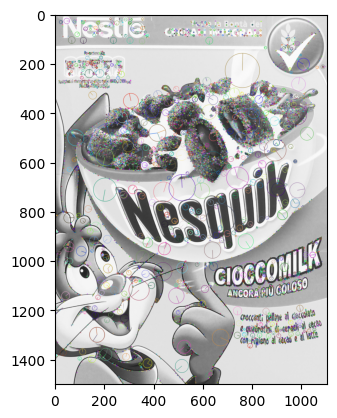

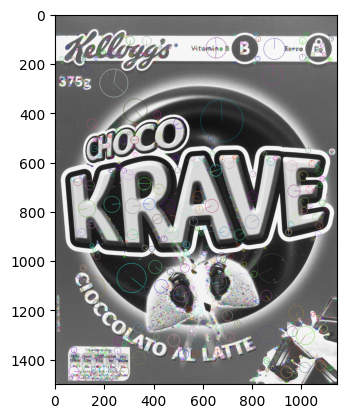

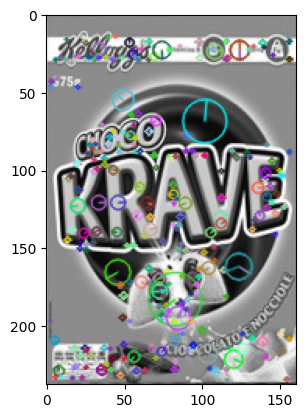

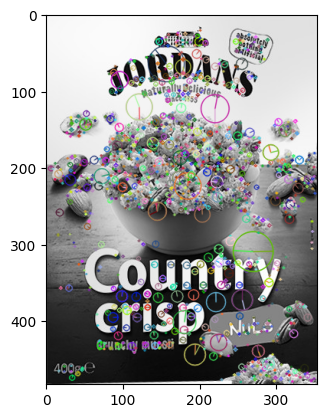

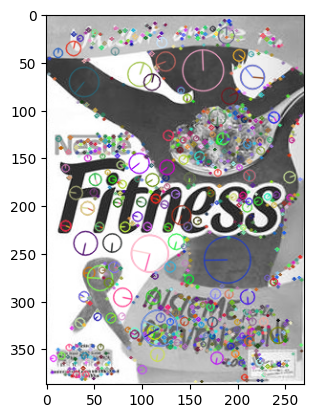

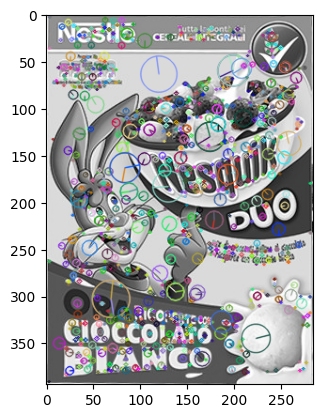

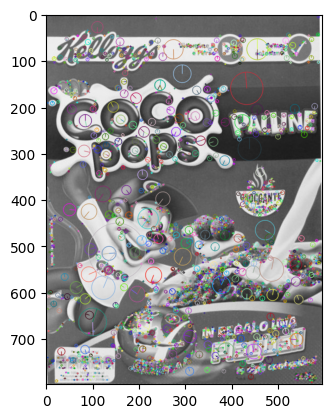

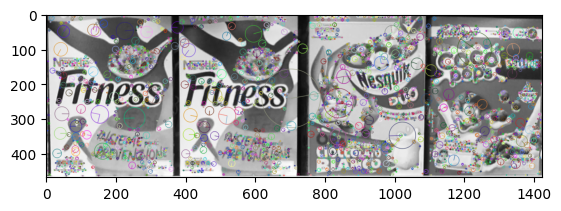

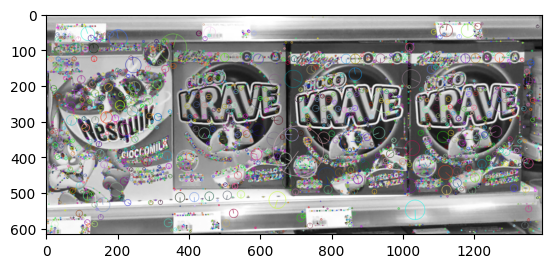

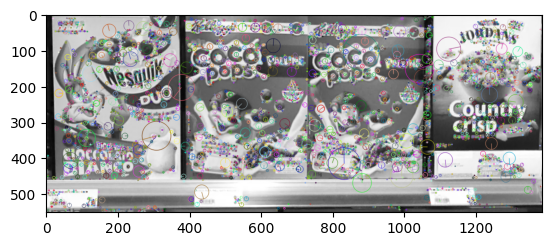

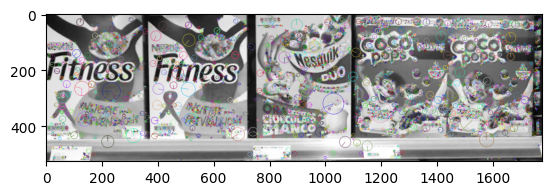

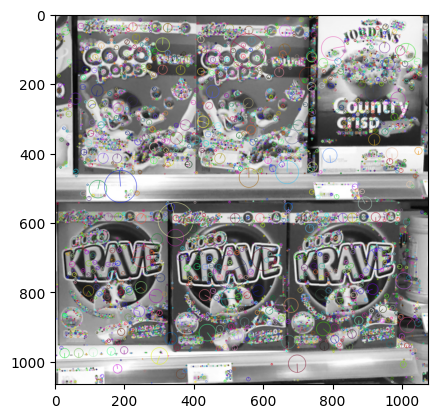

In [ ]:
image_dict = {}
models_dict = {}
scenes_dict = {}
description_dict = {}
description_models = []
description_scenes = []

def compute_keypoints(images, sift):
  image_dict = {}
  description_dict = {}
  for i in range(len(images)):
    keypoints, descr = sift.detectAndCompute(images[i], None)
    description_dict[i] = descr
    image_dict[i] = {'keypoints': keypoints, 'description': descr}
    img_visualization = cv2.drawKeypoints(images[i],keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_visualization)
    plt.show()
  return image_dict, description_dict

models_dict, description_models = compute_keypoints(references_gray, sift)
scenes_dict, description_scenes = compute_keypoints(scene_gray, sift)


**Matching Keypoints**

In [ ]:
def matchingKeypoints(descr_scene,descr_ref, kp_scene):
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  # Matching the descriptors
  matches = flann.knnMatch(descr_scene,descr_ref,k=2)
  #get first good matches
  first_good_matches = {}
  for m,n in matches:
    if m.distance < 0.55*n.distance:
      first_good_matches[kp_scene[m.queryIdx]] = m
  #get matched Keypoints in the scene
  dst = []
  for k,m in first_good_matches.items():
    dst.append((k,m.trainIdx))
  return first_good_matches, dst

This step differs from the previous one in that there might be multiple identical boxes on the shelf, and therefore, all instances must be recognized. To obtain the Bounding Boxes of all the models in the scene, i use a series of functions that compute the GHT function.
This Generalized Hough transformation, instead of relying on the classical R-Table, leverages the joining vectors calculated in the previous step for each model.

Calculation of the **keypoints' centroid** of the model

In [ ]:
def computeBaryCenter(kp_model):
  x_mean = np.mean(list(key_points.pt[0] for key_points in kp_model))
  y_mean = np.mean(list(key_points.pt[1] for key_points in kp_model))
  return x_mean, y_mean

`vectorsToBarycenter(kp_model, barycenter)` calculates and returns a set of vectors from the keypoints of the model to the specified barycenter.

In [ ]:
def vectorsToBarycenter(kp_model, barycenter):
  vectors = {}
  x_coords = list(key_points.pt[0] for key_points in kp_model)
  y_coords = list(key_points.pt[1] for key_points in kp_model)
  vectors = [(barycenter[0] - x, barycenter[1] - y) for x,y in zip(x_coords,y_coords)]
  return vectors

the `vote(shape_gray_scene, dst_points, vectors, kp_reference)` function is tasked with computing, for each Keypoint in the scene that matches a Keypoint in the model, its vote regarding the position of the barycenter within the scene itself. At this stage, the previously calculated joining vectors are utilized: they are appropriately resized, rotated, and added to the coordinates of the point to determine its vote. All these votes are then stored in an Accumulator Array, sized identically to the input image.








In [ ]:
def vote(shape_gray_scene, dst_points, vectors, kp_reference):
  votes = []
  accomulator = np.zeros(shape_gray_scene)
  for i in range(len(dst_points)):
    vec = vectors[dst_points[i][1]]
    scale = dst_points[i][0].size / kp_reference[dst_points[i][1]].size
    rot = (dst_points[i][0].angle - kp_reference[dst_points[i][1]].angle) * np.pi/180
    #rotation matrix
    rotmat = np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    #Apply the rotation to the vector vec using the rotation matrix rotmat and scale it.
    vec = rotmat @ vec
    vec = (scale*vec[0], scale*vec[1])

    vote = [sum(tup) for tup in zip(dst_points[i][0].pt, vec)]
    #check if the vote is smaller or bigger than the image's shape
    if(vote[0]>= 0 and vote[0]<= shape_gray_scene[1] and vote[1]>= 0 and vote[1] <= shape_gray_scene[0]):
        accomulator[int(vote[1]), int(vote[0])] += 1
        votes.append([dst_points[i][0], (int(vote[0]), int(vote[1]))])
  return accomulator, votes

In [ ]:
def getAccumulatorList(accumulator):
    l = []
    row, col = accumulator.shape
    # Using numpy's "argwhere" to get indices where accumulator values are greater than or equal to 1
    indices = list(zip(*np.argwhere(accumulator >= 1).T))
    for index in indices:
        l.append([index[1], index[0]])  # Appending [col, row] pairs
    return l


`discardOutliers` function analyzes the Accumulator Array, identifies outliers based on a specified limit and minimum count, and returns a list of barycenter points without the identified outliers.
So this function removes votes that are located far from the areas of the
image where most of the votes are concentrated.

In [ ]:
def discardOutliers(accumulator, limit, min_count):
  row, col = accumulator.shape
  removed_bar = []
  accList = getAccumulatorList(accumulator)
  res = accList.copy()

  for k in range(len(res)):
      x, y = accList[k]
      start_row = max(y - limit, 0)
      start_col = max(x - limit, 0)
      end_row = min(y + limit, row)
      end_col = min(x + limit, col)

      count = accumulator[start_row:end_row, start_col:end_col].sum()
      if count < min_count:
          removed_bar.append(accList[k])
  # Using list comprehension to filter the outliers
  res = [elem for elem in res if elem not in removed_bar]
  return res

`filterBarycenters` aims to filter barycenters based on a given distance threshold.
It groups all the votes, which fall within a certain range of given
amplitude, in a single one, calculated as their average.
Pratically identifies nearby barycenters within a certain distance and merges them into single representative points by calculating their average positions. It ensures that only unique and non-analyzed barycenters are considered in the final list **filtered_barycenters**.

In [ ]:
def filterBarycenters(barycenters, distance):
    def euclidianDistance(point1, point2):
        return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5

    filtered_barycenters = []
    for i in range(len(barycenters)):
        if barycenters[i] != (-1, -1):  # Exclude already analyzed points
            sum_x, sum_y = barycenters[i]
            count = 1
            for j in range(i + 1, len(barycenters)):
                if barycenters[j] != (-1, -1):  # Exclude already analyzed points
                    dist = euclidianDistance(barycenters[i], barycenters[j])
                    if dist < distance:
                        sum_x += barycenters[j][0]
                        sum_y += barycenters[j][1]
                        count += 1
                        barycenters[j] = (-1, -1)  # Mark as analyzed
            filtered_barycenters.append((round(sum_x / count), round(sum_y / count)))

    return filtered_barycenters


In [ ]:
barycenter = {}
vectors = {}

for i in range(len(models_dict)):
  kp_reference = models_dict[i]['keypoints']
  barycenter[i] = computeBaryCenter(kp_reference)
  vectors[i] = vectorsToBarycenter(kp_reference, barycenter[i])

The `get_correct_kp `function returns for each barycenter found the set of
associated scene KeyPoints.
In particolar for each vote checks if the vote is within the image boundaries (both x and y coordinates must be greater than 0 and less than the respective dimensions of the image).
Verifies whether the x and y coordinates of the vote fall within a square area defined by the barycenter's limits plus or minus the value of 'limit'.

In [ ]:
def get_correct_kp(barycenter, votes, shape_scene, good, limit):

    correct_kps = [good[vote[0]] for vote in votes
                  if (0 < int(vote[1][0]) < shape_scene[1] and 0 < int(vote[1][1]) < shape_scene[0])
                  and (barycenter[0] - limit < int(vote[1][0]) < barycenter[0] + limit)
                  and (barycenter[1] - limit < int(vote[1][1]) < barycenter[1] + limit)]
    return correct_kps

As in the previous stepA, the `mask` function is implemented to perform multiple operations besides calculating the homography via RANSAC. It also applies a color filtering for areas that might be confusing. This filtering compares the difference between the average colors of the model and various areas in the scene. If this difference falls below a certain color threshold, the algorithm proceeds with the filtering operation.

It's important to note, of course, that the mask implemented in step B takes as input the keypoints correctly filtered by the function defined earlier.

In [ ]:
MIN_MATCH_COUNT = 30
def masking_stepB(scene, rgb_scene, models_rgb, models_dict, kp_scene, keypoints, barycenters):
  count_product = 0
  recognised = {}
  rgb_scene_bb = rgb_scene
  #Sort the dictionary of dictionaries based on the length of the DMatch arrays (in descending order)
  correctKP_sorted = dict(sorted(keypoints.items(), key=lambda x: sum(len(subvalue) for subvalue in x[1].values()), reverse=True))

  for i, sub_dict in correctKP_sorted.items():
    kp_model = models_dict[i]['keypoints']
    count_product = 0
    center_for_ref = {}
    mask_w = {}
    mask_h = {}
    for j, val in sub_dict.items():
      if (len(correctKP_sorted[i][j])) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_model[m.trainIdx].pt for m in correctKP_sorted[i][j]]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_scene[m.queryIdx].pt for m in correctKP_sorted[i][j]]).reshape(-1,1,2)

        # Calculating homography based on correspondences
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        h, w, channels = models_rgb[i].shape
        h_scene,w_scene = scene.shape

        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))
        x1 = int((dst[0,0,0] + dst[1,0,0]) / 2) if (int((dst[0,0,0] + dst[1,0,0]) / 2) > 0) else 0
        y1 = int((dst[0,0,1] + dst[3,0,1]) / 2) if (int((dst[0,0,1] + dst[3,0,1]) / 2) > 0) else 0
        x2 = int((dst[2,0,0] + dst[3,0,0]) / 2) if (int((dst[2,0,0] + dst[3,0,0]) / 2) < w_scene) else w_scene
        y2 = int((dst[1,0,1] + dst[2,0,1]) / 2) if (int((dst[1,0,1] + dst[2,0,1]) / 2) < h_scene) else h_scene

        query_color = models_rgb[i].mean(axis=0).mean(axis=0)
        train_crop = rgb_scene[y1:y2,x1:x2]
        train_color = train_crop.mean(axis=0).mean(axis=0)

        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(query_color - train_color)]))

        ok_color = True
        if color_diff < 50:
          for r, corners in recognised.items():
              r_center = ((corners[0, 0, 0] + corners[1, 0, 0] + corners[2, 0, 0] + corners[3, 0, 0]) / 4,
                          (corners[0, 0, 1] + corners[1, 0, 1] + corners[2, 0, 1] + corners[3, 0, 1]) / 4)

              x1_min, y1_min = min(corners[0, 0, 0], corners[1, 0, 0]), min(corners[0, 0, 1], corners[3, 0, 1])
              x2_max, y2_max = max(corners[2, 0, 0], corners[3, 0, 0]), max(corners[1, 0, 1], corners[2, 0, 1])

              if (x1_min < center[0] < x2_max and y1_min < center[1] < y2_max) or (x1 < r_center[0] < x2 and y1 < r_center[1] < y2):
                ok_color = False
                break

          if ok_color:
            recognised[i] = dst
            center_for_ref[count_product] = center
            rgb_scene_bb = cv2.polylines(rgb_scene,[np.int32(recognised[i])],True,(0,255,0),3, cv2.LINE_AA)
            rgb_scene_bb = cv2.putText(rgb_scene_bb, text_models[i] , [np.int32(center[0]), np.int32(center[1])], 16, 2, (0, 255, 0), 8, cv2.LINE_AA)
            mask_w[count_product] = int(((dst[3, 0, 0] - dst[0, 0, 0]) + (dst[2, 0, 0] - dst[1, 0, 0])) /2)
            mask_h[count_product]  = int(((dst[1, 0, 1] - dst[0, 0, 1]) + (dst[2, 0, 1] - dst[3, 0, 1])) /2)
            count_product += 1

    print("Product " + text_models[i] + " – " + str(count_product) + " instance/s found" )

    if count_product > 0:
      for k in range(count_product):
        center_round = tuple([round(x) if isinstance(x, float) else x for x in center_for_ref[k]])
        # Drawing bounding box
        print("\tIstance {Position: " + str(center_round) + ", width:" + str(mask_w[k] ) + "px, height:" + str(mask_h[k]) + "px }")
  plt.imshow(cv2.cvtColor(rgb_scene_bb,cv2.COLOR_BGR2RGB))
  plt.show()

  return recognised

Scene m1 : 
Product 24 – 2 instance/s found
	Istance {Position: (184, 213), width:353px, height:500px }
	Istance {Position: (550, 219), width:334px, height:489px }
Product 26 – 1 instance/s found
	Istance {Position: (922, 219), width:333px, height:486px }
Product 25 – 1 instance/s found
	Istance {Position: (1261, 232), width:312px, height:441px }
Product 0 – 0 instance/s found
Product 1 – 0 instance/s found
Product 11 – 0 instance/s found
Product 19 – 0 instance/s found


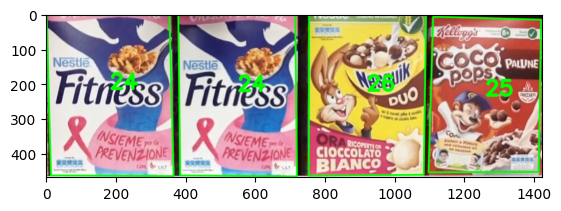

Scene m2 : 
Product 1 – 2 instance/s found
	Istance {Position: (1181, 255), width:302px, height:407px }
	Istance {Position: (849, 258), width:312px, height:410px }
Product 11 – 1 instance/s found
	Istance {Position: (511, 252), width:307px, height:402px }
Product 0 – 1 instance/s found
	Istance {Position: (179, 300), width:343px, height:448px }
Product 25 – 0 instance/s found
Product 26 – 0 instance/s found
Product 19 – 0 instance/s found
Product 24 – 0 instance/s found


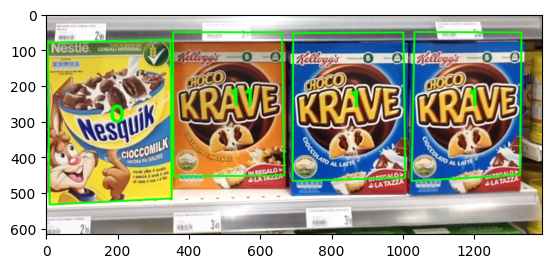

Scene m3 : 
Product 25 – 2 instance/s found
	Istance {Position: (557, 220), width:334px, height:454px }
	Istance {Position: (890, 285), width:355px, height:555px }
Product 26 – 1 instance/s found
	Istance {Position: (195, 206), width:354px, height:505px }
Product 19 – 1 instance/s found
	Istance {Position: (1233, 190), width:295px, height:383px }
Product 0 – 0 instance/s found
Product 1 – 0 instance/s found
Product 11 – 0 instance/s found
Product 24 – 0 instance/s found


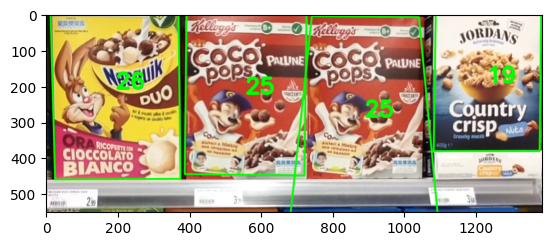

Scene m4 : 
Product 24 – 2 instance/s found
	Istance {Position: (161, 192), width:363px, height:508px }
	Istance {Position: (540, 196), width:348px, height:499px }
Product 25 – 2 instance/s found
	Istance {Position: (1280, 276), width:358px, height:577px }
	Istance {Position: (1589, 287), width:342px, height:575px }
Product 26 – 1 instance/s found
	Istance {Position: (922, 196), width:340px, height:493px }
Product 0 – 0 instance/s found
Product 1 – 0 instance/s found
Product 11 – 0 instance/s found
Product 19 – 0 instance/s found


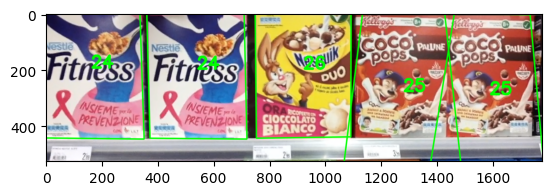

Scene m5 : 
Product 1 – 2 instance/s found
	Istance {Position: (832, 718), width:302px, height:408px }
	Istance {Position: (500, 721), width:313px, height:410px }
Product 25 – 2 instance/s found
	Istance {Position: (233, 223), width:335px, height:458px }
	Istance {Position: (566, 229), width:321px, height:447px }
Product 11 – 1 instance/s found
	Istance {Position: (163, 713), width:306px, height:402px }
Product 19 – 1 instance/s found
	Istance {Position: (909, 190), width:295px, height:384px }
Product 0 – 0 instance/s found
Product 24 – 0 instance/s found
Product 26 – 0 instance/s found


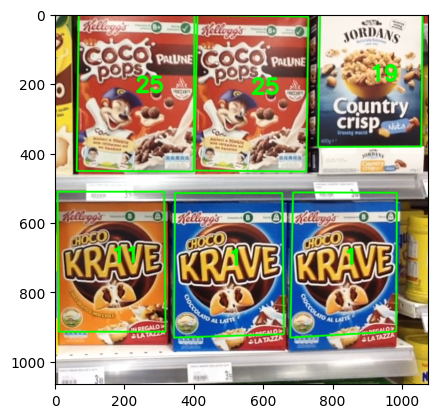

In [ ]:
import collections
from operator import itemgetter

for i in range(len(description_scenes)):
  correctKP = {}
  barycenters_filtered = {}
  kp_scene = scenes_dict[i]['keypoints']
  current_scene = scene_gray[i]
  s_descr = description_scenes[i]
  current_scene_rgb = scene_rgb[i]
  for j in range(len(description_models)):
    kp_reference = models_dict[j]['keypoints']
    r_descr = description_models[j]

    #Start to compute GHT
    first_good_matches, dst_points = matchingKeypoints(s_descr, r_descr, kp_scene)
    acc, votes = vote(current_scene.shape, dst_points, vectors[j], kp_reference)
    bar_no_outliers = discardOutliers(acc, 25, 15)
    barycenters_filtered[j] = filterBarycenters(bar_no_outliers, 150)
    correctKP[j] = {}
    for k in range(len(barycenters_filtered[j])):
      correctKP[j][k] = get_correct_kp(barycenters_filtered[j][k], votes, current_scene.shape, first_good_matches, 150)
  print("Scene " + text_scenes[i] + " : ")
  masking_stepB(current_scene, current_scene_rgb, references_rgb, models_dict, kp_scene, correctKP, barycenters_filtered)
